In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from pkg import pkg
from pkg import save
from osgeo import gdal
import spenv

In [2]:
ee.Authenticate()
ee.Initialize()
coordenadas = "-51.821964,3.925200,-51.775912,3.874524"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2018-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])


sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    
v_emit_asc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

image = ee.Image(dummy_value).blend(v_emit_desc.map(pkg.add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

In [3]:
latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=13)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[3.8998619999999997, -51.798938], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [4]:
df = pkg.ee_to_pandas(image, geom, image_names, scale=10)

In [5]:
renamed = pkg.rename_geodf(df)
reordered = renamed.reindex(sorted(renamed.columns), axis=1)

In [6]:
def scale_all(df):
    names = df.columns
    mat = df.to_numpy()
    scaled_mat = (mat - np.mean(mat)) / np.std(mat)
    return pd.DataFrame(scaled_mat, columns=names)


coords = reordered.loc[:, ['latitude','longitude']]

scaled = scale_all(reordered.drop(['latitude','longitude'], axis=1)).join(coords)

In [7]:
col_names = scaled.drop(['latitude','longitude'], axis=1).columns
save.save_tiff_from_df(scaled, col_names, dummy_value, r"assets/scaled.tif", "EPSG:4326")

True

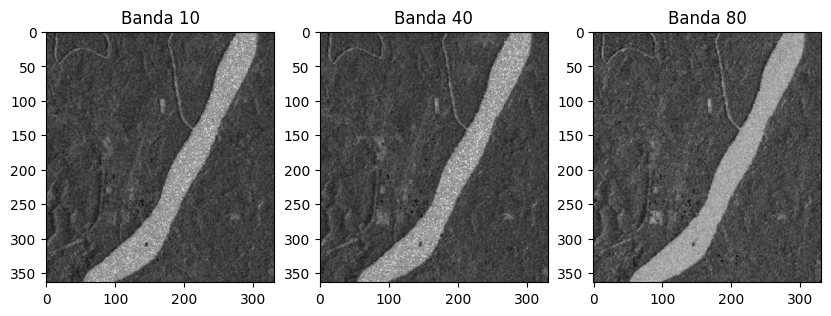

In [11]:
f = plt.figure(figsize=(10, 10))
examples = [10, 40, 80]

for i, j in enumerate(examples):
    f.add_subplot(1, 3, i+1).set_title("Banda " + str(j))
    pkg.show_tif('assets/scaled.tif', j)

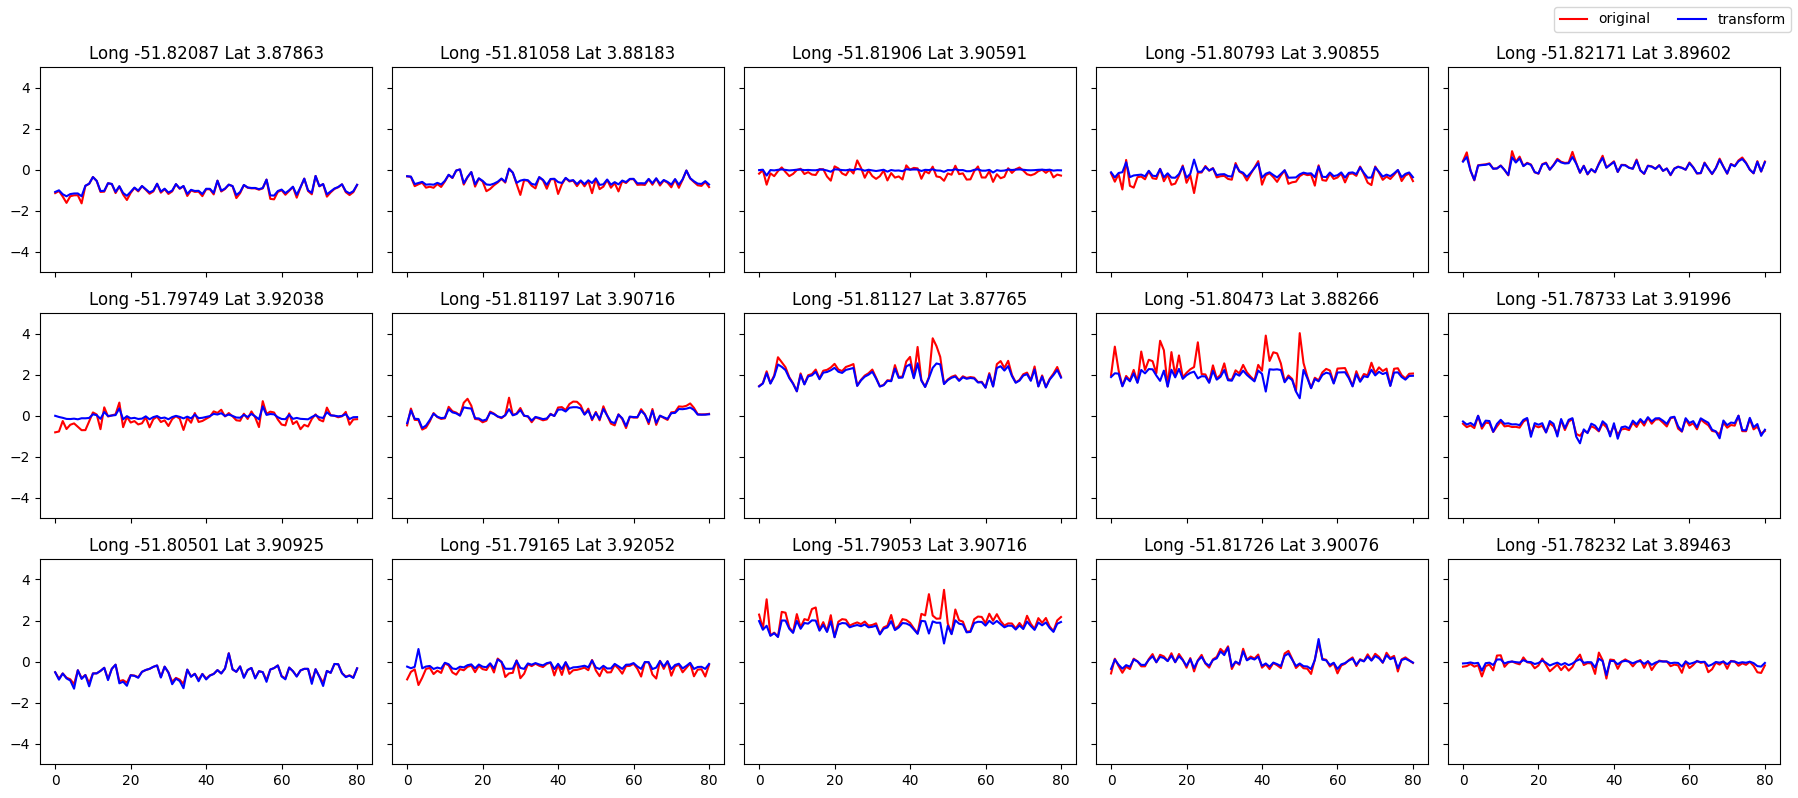

In [26]:
n_sample = 15
fig, axs = plt.subplots(3, 5, figsize=(18, 8), sharex=True, sharey=True)

pixels = random.sample(range(1, scaled.shape[0]), n_sample)

for i, ax in zip(pixels, axs.ravel()):
    test = scaled\
        .drop(['latitude', 'longitude'], axis=1)\
        .iloc[i, :]\
        .values\
        .reshape((-1, 1))

    xdata = np.concatenate((test, abs(test)**5), axis=1)

    envelope = spenv.specenv(xdata)

    b = envelope[envelope[:, 1] == max(envelope[:, 1]), 2:]
    opt = np.sum(xdata*b, axis=1)

    long = str(round(scaled.longitude[i], 5))
    lat = str(round(scaled.latitude[i], 5))

    ax.plot(test, color="r")
    ax.plot(opt, color='b')
    ax.set_title("Long " + long + " Lat " + lat)
    ax.set_ylim(-5, 5)

fig.tight_layout()
fig.legend(labels=['original', 'transform'], ncol=2, loc='upper right')
fig.subplots_adjust(top=0.92)

# fig.savefig("assets/transforms.png")

In [32]:
optimized = scaled\
    .drop(['latitude', 'longitude'], axis=1)\
    .apply(lambda x: spenv.spec_opt(x, lambda y: abs(y)**5, as_series=True))

In [33]:
optimal = optimized.join(coords)
cols = optimized.columns
path = r'assets/optimized.tif'
save.save_tiff_from_df(optimal, cols, dummy_value, path, "EPSG:4326")

True

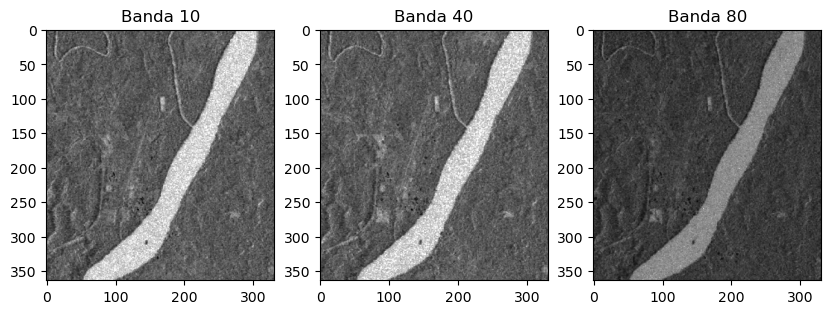

In [2]:
f = plt.figure(figsize=(10, 10))
examples = [10, 40, 80]

for i, j in enumerate(examples):
    f.add_subplot(1, 3, i+1).set_title("Banda " + str(j))
    pkg.show_tif('assets/optimized.tif', j)

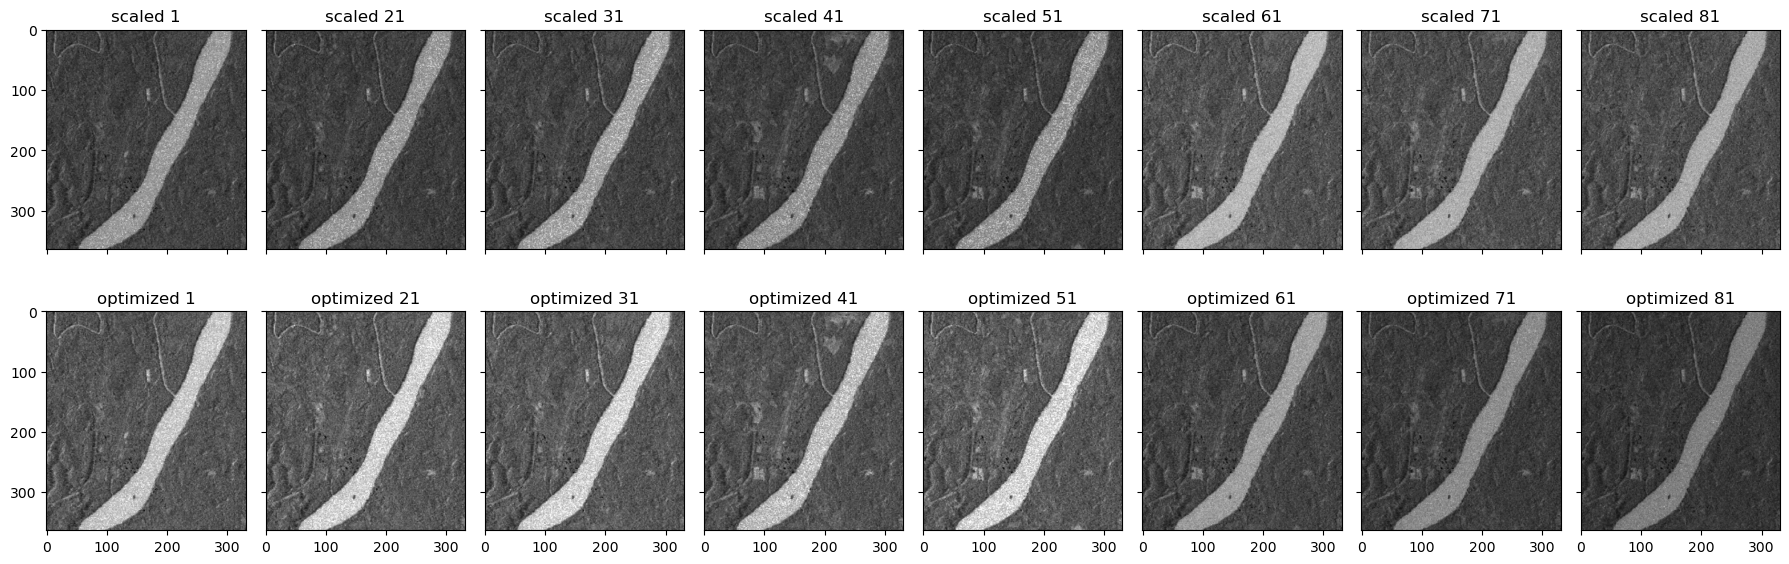

In [3]:
examples = [1, 21, 31, 41, 51, 61, 71, 81]
imagens = ["scaled", "optimized"]
plots = [(x, y) for x in imagens for y in examples]

fig, axs = plt.subplots(2, 8, figsize=(18, 6), sharex=True, sharey=True)

for plot, ax in zip(plots, axs.ravel()):
    ax.set_title(plot[0] + " " + str(plot[1]))
    raster = gdal.Open("assets/" + plot[0] + ".tif")
    img = raster.GetRasterBand(plot[1]).ReadAsArray()
    ax.imshow(img, cmap = "gray")

fig.tight_layout()

#fig.savefig("assets/comparison.png")

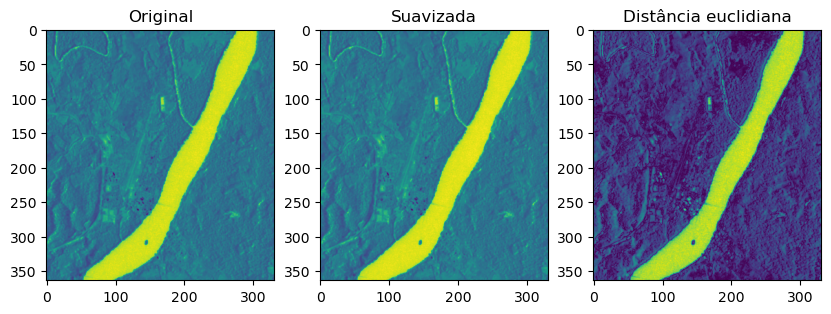

In [4]:
I = gdal.Open(r'assets/scaled.tif').ReadAsArray()
Im = I.mean(axis=0)

X = gdal.Open(r'assets/optimized.tif').ReadAsArray()
Xm = X.mean(axis=0)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1).set_title("Original")
plt.imshow(Im, "viridis")
fig.add_subplot(1,3,2).set_title("Suavizada")
plt.imshow(Xm, "viridis")
fig.add_subplot(1,3,3).set_title("Distância euclidiana")
plt.imshow(np.sqrt(Im**2 + Xm**2), "viridis")

In [5]:
D = np.ndarray(X.shape)

for i in range(0, X.shape[0]):
    D[i, :, :] = (X[i, :, :] - Im)**2

D.shape

(81, 364, 331)

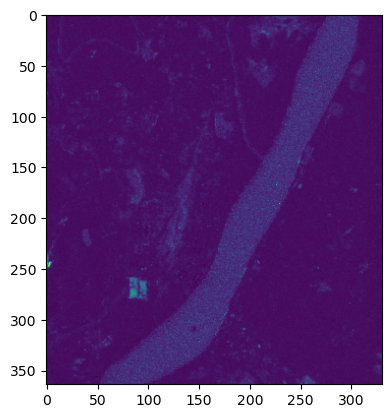

In [6]:
plt.imshow(D.mean(axis=0))

In [7]:
d = D.sum(axis=(1, 2)).ravel()

In [8]:
R = np.ndarray(Im.shape)

for i in range(0, X.shape[1]):
    for j in range(0, X.shape[2]):
        R[i, j] = np.abs(np.corrcoef(d, D[:, i, j])[0][1])

R.shape

(364, 331)

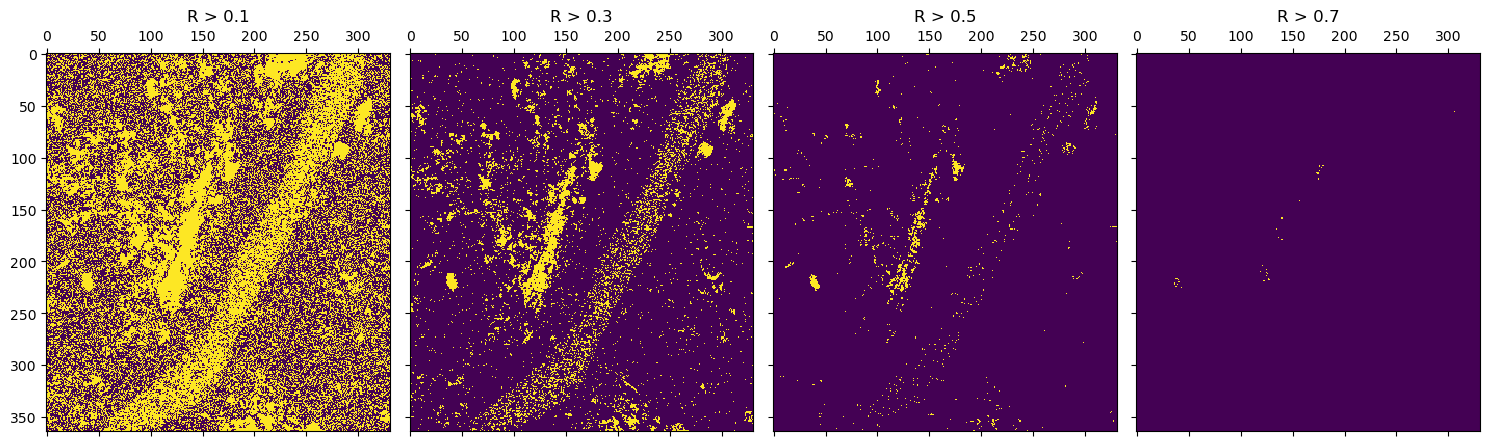

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 15), sharex=True, sharey=True)
lims = [0.1, 0.3, 0.5, 0.7]

for lim, ax in zip(lims, axs):
    ax.matshow(R > lim)
    ax.set_title("R > " + str(lim))
    
fig.tight_layout()